# Wound Area Calculation Utilities

This cell defines utility functions essential for calculating the wound area (in mm²) from the annotated polygon coordinates.

1) import statements load necessary libraries:

    - os, json, pandas, numpy for file/data handling and computation.
    - matplotlib.pyplot for future visualizations.

2) polygon_area(x_points, y_points):

    - Computes the area enclosed by a polygon using the Shoelace formula.
    - np.roll shifts elements to apply the cross multiplication logic required
      by the formula.

3) convert_pixels_to_mm2(area_pixels, pixel_to_mm=0.264583):

    - Converts area from pixels² to mm².
    - Assumes default resolution: 1 pixel ≈ 0.264583 mm (standard for 96 DPI).

4) get_area_from_shape(region_shape_json):

    - Parses the region_shape_attributes field (JSON string).
    - Extracts all_points_x and all_points_y for the polygon.
    - Computes pixel area → converts it to mm² → returns it.
    - If parsing fails, returns None and logs the issue.

This cell acts as the computational backbone of wound area extraction from annotated polygon data.

In [ ]:
import os
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

def polygon_area(x_points, y_points):
    x = np.array(x_points)
    y = np.array(y_points)
    return 0.5 * abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def convert_pixels_to_mm2(area_pixels, pixel_to_mm=0.264583):
    return area_pixels * (pixel_to_mm ** 2)

def get_area_from_shape(region_shape_json):
    try:
        shape_dict = json.loads(region_shape_json)
        if shape_dict.get("name") == "polygon":
            x = shape_dict["all_points_x"]
            y = shape_dict["all_points_y"]
            pixel_area = polygon_area(x, y)
            mm_area = convert_pixels_to_mm2(pixel_area)
            return mm_area
    except Exception as e:
        print(f"Error parsing shape: {e}")
    return None


# Clean Upload Directory and Upload Fresh Files

Deletes all old .csv, .zip, .jpg, and .png files from /content to avoid clutter, then opens a file upload dialog for fresh uploads.

In [ ]:
import os
from google.colab import files

uploaded_dir = '/content'
for fname in os.listdir(uploaded_dir):
    if fname.endswith(('.csv', '.zip', '.jpg', '.png')):
        try:
            os.remove(os.path.join(uploaded_dir, fname))
        except:
            pass

uploaded = files.upload()


Saving Rat Wounds.zip to Rat Wounds.zip


# Extract Uploaded ZIP File

This cell extracts the uploaded Rat Wounds.zip file into a new directory named /content/my_extracted_folder/. It also confirms successful extraction by listing the folder contents.

In [ ]:
import zipfile
import os

zip_file = "Rat Wounds.zip"
extract_path = "/content/my_extracted_folder/"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Files are in:", extract_path)
print(os.listdir(extract_path))


Extraction complete! Files are in: /content/my_extracted_folder/
['Rat Wounds']


# Parse Annotations and Calculate Wound Area

Purpose:

    This cell iterates through each rat category folder, reads the
    corresponding annotation CSV, extracts wound polygon coordinates,
    calculates wound area in mm² using the Shoelace formula, and compiles all
    data into a structured DataFrame.

Key Actions:

    - Extracts metadata (category, rat number, day).
    - Parses polygon coordinates from JSON string.
    - Calculates wound area in mm².
    - Organizes parsed results into master_df, sorted by category, rat number,
      and day.

In [ ]:
import re

root_dir = "/content/my_extracted_folder/Rat Wounds/Rat_wounds"

all_data = []

for rat_folder in os.listdir(root_dir):
    rat_path = os.path.join(root_dir, rat_folder)
    if not os.path.isdir(rat_path):
        continue

    match = re.match(r"(Control|Drug|Standard)\s*(\d+)", rat_folder)
    if not match:
        continue
    category = match.group(1)
    rat_number = int(match.group(2))

    annotation_filename = f"{rat_folder} Annotations.csv"
    annotation_path = os.path.join(rat_path, annotation_filename)

    if not os.path.exists(annotation_path):
        print(f"Annotation file not found: {annotation_filename}")
        continue

    df = pd.read_csv(annotation_path)
    for _, row in df.iterrows():
        filename = row['filename']
        shape_json = row['region_shape_attributes']

        day_match = re.search(r'\((\d+)\)', filename)
        if not day_match:
            continue
        day = int(day_match.group(1))

        area_mm2 = get_area_from_shape(shape_json)
        if area_mm2 is not None:
            all_data.append({
                'category': category,
                'rat_number': rat_number,
                'day': day,
                'area_mm2': area_mm2
            })

master_df = pd.DataFrame(all_data)
master_df = master_df.sort_values(by=['category', 'rat_number', 'day'])

print(f"Total wound records parsed: {len(master_df)}")
master_df.head()


Total wound records parsed: 84


,category,rat_number,day,area_mm2
0,Control,1,1,3051.901529
1,Control,1,3,5963.514713
2,Control,1,5,2009.014497
3,Control,1,7,991.643984
4,Control,1,9,839.699946


# Create Pivot Table of Wound Areas

Purpose:

    This cell restructures the master_df DataFrame into a more readable format
    showing wound area (in mm²) across all days for each rat.

Key Actions:

    - Uses pivot() to reshape data with category and rat_number as row
      identifiers and day values as columns.

    - Renames day columns to a clearer format (e.g., "Day 1", "Day 3", ...).

    - Rounds all wound area values to two decimal places for clarity.

    - Resets the index to flatten the DataFrame structure for easier viewing.

In [ ]:
table = master_df.pivot(
    index=['category', 'rat_number'],
    columns='day',
    values='area_mm2'
)

table.columns = [f"Day {int(col)}" for col in table.columns]

table = table.round(2)

table.reset_index(inplace=True)

table


,category,rat_number,Day 1,Day 3,Day 5,Day 7,Day 9,Day 11,Day 13
0,Control,1,3051.90,5963.51,2009.01,991.64,839.70,462.55,534.97
1,Control,2,948.56,1355.49,1137.11,784.92,1020.49,1180.03,722.93
2,Control,3,809.70,532.17,785.27,364.55,319.74,568.15,554.68
3,Control,4,1108.45,1312.37,1096.41,634.52,334.23,728.29,751.88
4,Drug,1,749.74,292.23,437.81,656.18,212.18,209.77,80.26
5,Drug,2,833.64,454.01,444.07,218.94,231.99,528.18,447.29
6,Drug,3,239.17,259.16,267.80,216.31,184.43,143.30,39.41
7,Drug,4,667.31,665.53,859.83,364.58,269.10,436.09,27.41
8,Standard,1,1321.64,658.74,605.05,782.82,436.79,602.91,833.89
9,Standard,2,1171.59,594.79,614.29,605.36,827.13,531.47,488.77


# Calculate Wound Healing Percentages

Purpose:

    This cell computes the percentage of wound healing for each rat over time,
    relative to the wound area on Day 1.

Key Actions:

    - Makes a copy of the original wound area table to preserve it.

    - Extracts Day 1 area values (day1_areas) for each rat.

    - Iterates over all day columns (starting from Day 3 onward) and computes:

          Healing % = ((Day 1 Area - Current Day Area) / Day 1 Area) * 100

    - Rounds each computed percentage to 2 decimal places.

    - Renames the columns to reflect that they represent healing percentages
      (e.g., Day 3 % Healed, Day 5 % Healed, etc.).

In [ ]:
healing_df = table.copy()

day1_areas = healing_df['Day 1']

for col in healing_df.columns[2:]:
    healing_df[col] = ((day1_areas - healing_df[col]) / day1_areas * 100).round(2)

healing_df.rename(columns={f"Day {d}": f"Day {d} % Healed" for d in [1,3,5,7,9,11,13]}, inplace=True)

healing_df


,category,rat_number,Day 1 % Healed,Day 3 % Healed,Day 5 % Healed,Day 7 % Healed,Day 9 % Healed,Day 11 % Healed,Day 13 % Healed
0,Control,1,0.0,-95.40,34.17,67.51,72.49,84.84,82.47
1,Control,2,0.0,-42.90,-19.88,17.25,-7.58,-24.40,23.79
2,Control,3,0.0,34.28,3.02,54.98,60.51,29.83,31.50
3,Control,4,0.0,-18.40,1.09,42.76,69.85,34.30,32.17
4,Drug,1,0.0,61.02,41.61,12.48,71.70,72.02,89.29
5,Drug,2,0.0,45.54,46.73,73.74,72.17,36.64,46.34
6,Drug,3,0.0,-8.36,-11.97,9.56,22.89,40.08,83.52
7,Drug,4,0.0,0.27,-28.85,45.37,59.67,34.65,95.89
8,Standard,1,0.0,50.16,54.22,40.77,66.95,54.38,36.90
9,Standard,2,0.0,49.23,47.57,48.33,29.40,54.64,58.28


# Plot Average Wound Healing Curves by Category

Purpose:
    
    To visualize the average wound area progression over days for each rat
    category (Control, Drug, Standard).

Key Actions:

    - Groups the wound area data by category and calculates the mean wound area
      for each day across all rats in that category.

    - Transposes the resulting dataframe for easier plotting (days become the
      index).

    - Creates a line plot showing average wound area (in mm²) over days.

    - Adds plot elements: title, axis labels, grid, and legend to clearly
      distinguish categories.

    - Adjusts layout for neat display and renders the plot.

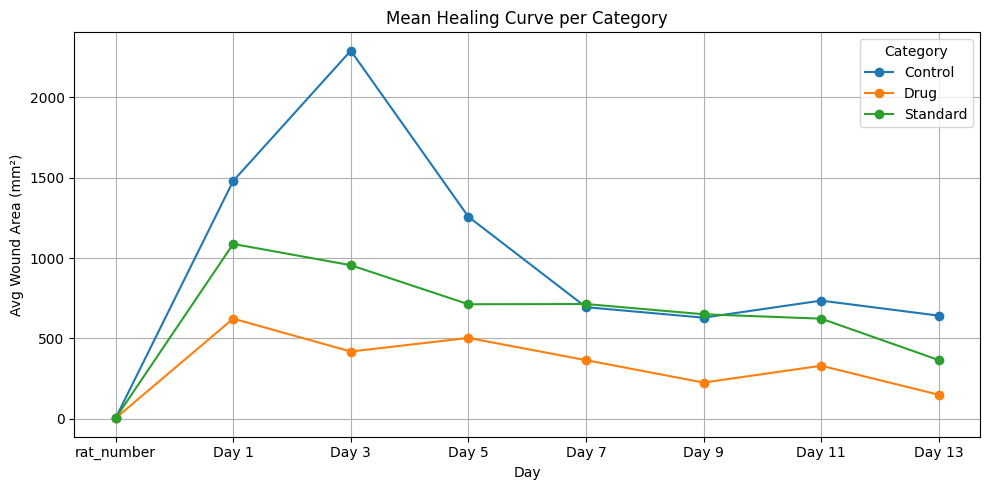

In [ ]:
mean_df = table.groupby('category').mean()

mean_df = mean_df.T

mean_df.plot(figsize=(10, 5), marker='o')
plt.title("Mean Healing Curve per Category")
plt.xlabel("Day")
plt.ylabel("Avg Wound Area (mm²)")
plt.grid(True)
plt.legend(title="Category")
plt.tight_layout()
plt.show()
